<a href="https://colab.research.google.com/github/dantrica/cement-based-composites/blob/main/analytics_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Modulo de análisis de datos provenientes de voltamperometrías, esfuerzo mecánico y potencial de circuito abierto.</h1>

<div align="right">Daniel A. Triana-Camacho, PhD(c)<br>Jorge H. Quintero-Orozco, Dr.



# 0.0. Librerías de inicialización del módulo

# 0.1. Cargar My Drive en servidor Colab

In [1]:
try: # Esto permite ejecución en ambiente local, sin afectar el uso en Colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    basePath = '/content/drive/My Drive/Colab_DanielTriana'
    %cd $basePath
except:
    pass

Mounted at /content/drive
/content/drive/My Drive/Colab_DanielTriana


## 0.2. Cargar librerías del sistema

In [2]:
import sys
import os
working_dir = os.getcwd()
script_dir = os.path.join(working_dir, 'scripts')
if not script_dir in sys.path:
    sys.path.append(script_dir)

## 0.3. Importando las librerias: lmfit, pro_data, ... desde ubicación en Google Drive.



In [3]:
#!pip  install --upgrade pandas
!pip install openpyxl==3.0.5
import openpyxl
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping 
from scipy.interpolate import interp1d
import scipy.stats as sta
import scipy.optimize as opt
import scipy.integrate as integral
#try:
#  from lmfit import Model
#except:
#  !pip install lmfit
#try:
#  import xlsxwriter
#except:
#  !pip install xlsxwriter
#from semiCirclesEISModel import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 242 kB 4.5 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


# 1.0. Correlación entre ensayos de esfuerzo mecánico y portencial de circuito abiero OCP.

## 1.1. Elegir muestras

In [4]:
data = pd.read_excel('data/Medidas_GO_20220406.xlsx')
#path_list = data.path
#measure = ['OCP', 'f']

ss1 = input("elegir muestras entre (p39 - p50), ejemplo: p39 p44 ...] : ")

def to_list(string):
    li = list(string.split(" "))
    return li
picked_samples = to_list(ss1)

elegir muestras entre (p39 - p50), ejemplo: p39 p44 ...] : p39


## 1.2. Diccionario con DataFrames que contiene la información posicionada por muestra 'pxx'.

In [6]:
# Recorrer sobre las muestras
# En cada muestra recorrer sobre las medidas de interes para crear un nuevo data frame

dic_info_by_sample = {}
dic_info_by_sample = dic_info_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  s_sample = data['specimen'] == ss1
  sx = data[s_sample]
  s_measure = (sx['measure'] == 'OCP') | (sx['measure'] == 'f')
  sx[s_measure] # DataFrame with electric-mechanic measurements by sample "pxx"
  dic_info_by_sample[ss1] = sx[s_measure] # DataFrames e-m by pxx into dictionary 

dic_info_by_sample

{'p39':                   time specimen measure serie measurement_date  \
 0  2022-05-10 22:18:00      p39     OCP     1       2022-04-06   
 12                 NaT      p39       f   NaN       2022-04-06   
 
    sample_fabrication_date                             path start_curing_date  \
 0               2020-02-29  20220406_e_Malaga/OCP_p39_1.txt        2020-03-02   
 12                     NaT          20220406_f_Malaga/f_p39               NaT   
 
    end_curing_date     concentration_nc   nc   energy      solvent  \
 0       2020-04-12  0.2259 g / 80 g H2O   GO  Branson  Agua tipo I   
 12             NaT                  NaN  NaN      NaN          NaN   
 
    electric_field                                            remarks  
 0         Ninguno  1)  Se preparó 0.2259 g de GO, el GO fue sonic...  
 12            NaN                                                NaN  }

## 1.3. Diccionario con los datos eléctricos y mecánicos por muestra 'pxx'

In [7]:
dic_data_by_sample = {}
dic_data_by_sample = dic_data_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  e_data = np.loadtxt('data/'+dic_info_by_sample[ss1].path.values[0]) # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
  e_t = e_data[:,0]*1e-3 #columna 1 tiempo en [s]
  v = -e_data[:,1]*1e3 #columna 2 voltaje en [mV]
  i = -e_data[:,2]*1e6 #columna 3 corriente en [uA]

  m_data = pd.read_excel('data/'+dic_info_by_sample[ss1].path.values[1]+'.xlsx') # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
  m_data.columns = m_data.iloc[1]
  m_data = m_data.drop([0,1,2])
  m_t = m_data['Tiempo'] # Segundos
  f = m_data['Fuerza']*9.8067/1000 # kN
  pos = m_data['Posición'] # mm

  dic_data_by_sample[ss1] = np.array([e_t, v, i, m_t, f, pos])

dic_data_by_sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


{'p39': array([array([  2.558,   3.558,   4.558,   5.558,   6.558,   7.558,   8.558,
                 9.558,  10.558,  11.558,  12.558,  13.558,  14.558,  15.558,
                16.558,  17.558,  18.558,  19.558,  20.558,  21.558,  22.558,
                23.558,  24.558,  25.558,  26.558,  27.558,  28.558,  29.558,
                30.558,  31.558,  32.558,  33.558,  34.558,  35.558,  36.558,
                37.558,  38.558,  39.558,  40.558,  41.558,  42.558,  43.558,
                44.558,  45.558,  46.558,  47.558,  48.558,  49.558,  50.558,
                51.558,  52.558,  53.558,  54.558,  55.558,  56.558,  57.558,
                58.558,  59.558,  60.558,  61.558,  62.558,  63.558,  64.558,
                65.558,  66.558,  67.558,  68.558,  69.558,  70.558,  71.558,
                72.558,  73.558,  74.558,  75.558,  76.558,  77.558,  78.558,
                79.558,  80.558,  81.558,  82.558,  83.558,  84.558,  85.558,
                86.558,  87.558,  88.558,  89.558,  90.55

## 1.4. Interpolaciones para $v$, $i$, $F$ y $\Delta L$ en función del tiempo $t$

In [8]:
def interpol(samples, dic_data, t_min_max=[2, 150], n=200):
  dic_idata_by_sample = {}
  dic_idata_by_sample = dic_idata_by_sample.fromkeys(samples)

  for ss2 in dic_data.keys():
    # medidas eléctricas
    e_t = dic_data[ss2][0] # índice "0": tiempo en [s]
    v = dic_data[ss2][1] # índice "1": voltaje en [mV]
    i = dic_data[ss2][2] # índice "2": corriente en [uA]

    # medidas mecánicas
    m_t = dic_data[ss2][3] # índice "3": tiempo en [s]
    try: # solución al error de np.array no tiene atributo values 
      m_tmi = m_t.values[0]
      m_tma = m_t.values[-1]
    except:
      m_tmi = m_t[0]
      m_tma = m_t[-1]
    f = dic_data[ss2][4] # índice "4": fuerza en [kN]
    pos = dic_data[ss2][5] # índice "5": deformación en [mm]

    # interpolación de variables dependientes del tiempo v, i, f, pos
    interpol_v = interp1d(e_t, v)
    interpol_i = interp1d(e_t, i)
    interpol_f = interp1d(m_t, f)
    interpol_pos = interp1d(m_t, pos)
    
    # Determinación del intervalo de tiempo  tmin y tmax
    if e_t[0] < m_tmi: #m_t.values[0]:
      t_min = m_tmi#m_t.values[0]
    else:
      t_min = e_t[0]
    if e_t[-1] < m_tma: #m_t.values[-1]:
      t_max = e_t[-1]
    else:
      t_max = m_tma#m_t.values[-1]

    if t_min_max[0] <= t_min:
      print('Debe seleccionar un tiempo mínimo mayor a %.2f [s]' %t_min)
    else:
      t_min = t_min_max[0]
    if t_min_max[-1] >= t_max:
      print('Debe seleccionar un tiempo máximo menor a %.2f [s]' %t_max)
    else:
      t_max = t_min_max[-1]

    i_t = np.linspace(t_min, t_max, n)

    dic_idata_by_sample[ss2] = np.array([i_t, interpol_v(i_t), interpol_i(i_t), 
                                         i_t, interpol_f(i_t), interpol_pos(i_t)])
    
  return dic_idata_by_sample

## 1.5. Método de graficación que combina $v(t)$, $i(t)$, $F(t)$ y $\Delta L(t)$

In [11]:
def plot_electromechanical(data, idata, option=0, marker='--', etiqueta='', dpi=90):
  ax = plt.figure(num=0, dpi = dpi)

  # Cantidades físicas sp
  #time = 'Tiempo'
  #force = 'Fuerza'
  #strain = 'Deformación'
  #uni_strain = r'Deformación unitaria'
  #voltage = 'Voltaje'
  #current = r'Corriente'
  #resistence = r'Resistencia'
  #DR_R0 = r'$\frac{\Delta R}{R_0}$'
  #power = 'Potencia'
  #force_area = r'$\frac{F}{A}$'
  #voltage_distance = r'$\frac{V}{d}$'

  # Cantidades físicas en
  time = 'Time'
  force = 'Load' # 'Strength'
  strain = 'Deformation'
  uni_strain = r'Strain'
  voltage = 'Voltage'
  current = r'Current'
  resistence = r'Resistance'
  DR_R0 = r'$\frac{\Delta R}{R_0}$'
  power = 'Power'
  force_area = r'Stress'
  voltage_distance = r'$\frac{V}{d}$'

  # Unidades
  u_time = ' [s]'
  u_force = ' [N]'
  u_strain = ' [mm]'
  u_uni_strain = r' [$\mu \epsilon$]'
  u_voltage = ' [mV]'
  u_current = r' [$\mu$A]'
  u_resistence = r' [k$\Omega$]'
  u_DR_R0 = r' [$\Omega/\Omega$]'
  u_power = ' [nW]'
  u_force_area = r' [$N/m^2$]'
  u_voltage_distance = r' [$V/m$]'


  for ss2 in picked_samples:

    # medidas eléctricas
    e_t = data[ss2][0] # índice "0": tiempo en [s]
    v = data[ss2][1] # índice "1": voltaje en [mV]
    i = data[ss2][2] # índice "2": corriente en [uA]

    i_e_t = idata[ss2][0] # índice "0": tiempo en [s]
    i_v = idata[ss2][1] # índice "1": voltaje en [mV]
    i_i = idata[ss2][2] # índice "2": corriente en [uA]

    # medidas mecánicas
    m_t = data[ss2][3] # índice "3": tiempo en [s]
    f = data[ss2][4]*1000 # índice "4": fuerza en [N]
    pos = data[ss2][5] # índice "5": deformación en [mm]

    i_m_t = idata[ss2][3] # índice "3": tiempo en [s]
    i_f = idata[ss2][4]*1000 # índice "4": fuerza en [N]
    i_pos = idata[ss2][5] # índice "5": deformación en [mm]

    norm = ''

    if option == 0:
      x, y, xlabel, ylabel = i_m_t, i_f, time+u_time, force+u_force
    elif option == 1:
      x, y, xlabel, ylabel = i_m_t, i_pos/60 * 1e6, time+u_time, uni_strain+u_uni_strain
    elif option == 2:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_f, uni_strain+u_uni_strain, force+u_force
    elif option == 3:
      x, y, xlabel, ylabel = i_e_t, i_v, time+u_time, voltage+u_voltage
    elif option == 4:
     x, y, xlabel, ylabel = i_e_t, i_i, time+u_time, current+u_current
    elif option == 5:
      x, y, xlabel, ylabel = i_v, i_i, voltage+u_voltage, current+u_current
    elif option == 6:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_v, uni_strain+u_uni_strain, voltage+u_voltage
    elif option == 7:
      x, y, xlabel, ylabel = i_f, i_v, force+u_force, voltage+u_voltage
    elif option == 8:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_i, uni_strain+u_uni_strain, current+u_current
    elif option == 9:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_v/i_i, uni_strain+u_uni_strain, resistence+u_resistence
    elif option == 10:
      x, y, xlabel, ylabel = i_f, i_v/i_i, force+u_force, resistence+u_resistence
    elif option == 11:
      x, y, xlabel, ylabel = i_e_t, i_v * i_i, time+u_time, power+u_power
    elif option == 12:
      x, y, xlabel, ylabel = i_e_t, i_v / i_i, time+u_time, resistence+u_resistence
    elif option == 13:
      R = i_v / i_i
      R0 = R.min()
      DR = R - R0
      x, y, xlabel, ylabel = i_pos/60 * 1e6, DR / R0, uni_strain+u_uni_strain, DR_R0+u_DR_R0
    elif option == 14:
      R = i_v / i_i
      R0 = R.min()
      DR = R - R0
      x, y, xlabel, ylabel = i_e_t, DR / R0, time+u_time, DR_R0
    elif option == 15:
      x, y, xlabel, ylabel = i_f*1e3 / (np.pi*(15e-3)**2), i_v*1e-3 / ( 20e-3 ), force_area+u_force_area, voltage_distance+u_voltage_distance
    elif option == 16:
      norm = 'Normalizada'
      x, y, xlabel, ylabel = i_m_t, i_pos/i_pos.max(), time+u_time, uni_strain+' '+norm
    elif option == 17:
      norm = 'Normalizada'
      x, y, xlabel, ylabel = i_e_t, i_i/i_i.max(), time+u_time, current+' '+norm
    
    # ------ Rutina temporal para regresión lineal -----------------------------
    x = x.astype('float')
    y = y.astype('float')
    y_m = ( y.max() + y.min() ) / 2 
    regre = sta.linregress(x, y)
    #print(regre.slope/1e3/20e-3*np.pi*(15e-3)**2*1e5, r' *10^{-5} mVm/N') # g33
    #print('\n')
    #print(regre.slope/1e6*1e12, r' pC/N') # d33
    #print(y_m)
    #print((y - y_m).max())
    # --------------------------------------------------------------------------

    if etiqueta == '':
      lab = ss2
    else:
      lab = etiqueta
    # Graficación de datos por muestra "pxx"
    if norm == 'Normalizada':
      plt.plot(x, y, marker, label=lab+' '+ylabel)
      plt.xlabel(xlabel)
      plt.ylabel(norm)
      plt.title(norm+' vs '+xlabel)
    else:
      plt.plot(x, y, marker, label=lab)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.title(ylabel+' vs '+xlabel)
    plt.legend()
  #plt.ylim(-5, 31) # modificar para voltaje_load

  #plt.show()
  return xlabel, ylabel, ax, regre

# 2.0. Llamado de métodos previos y presentación de datos

Debe seleccionar un tiempo mínimo mayor a 2.76 [s]


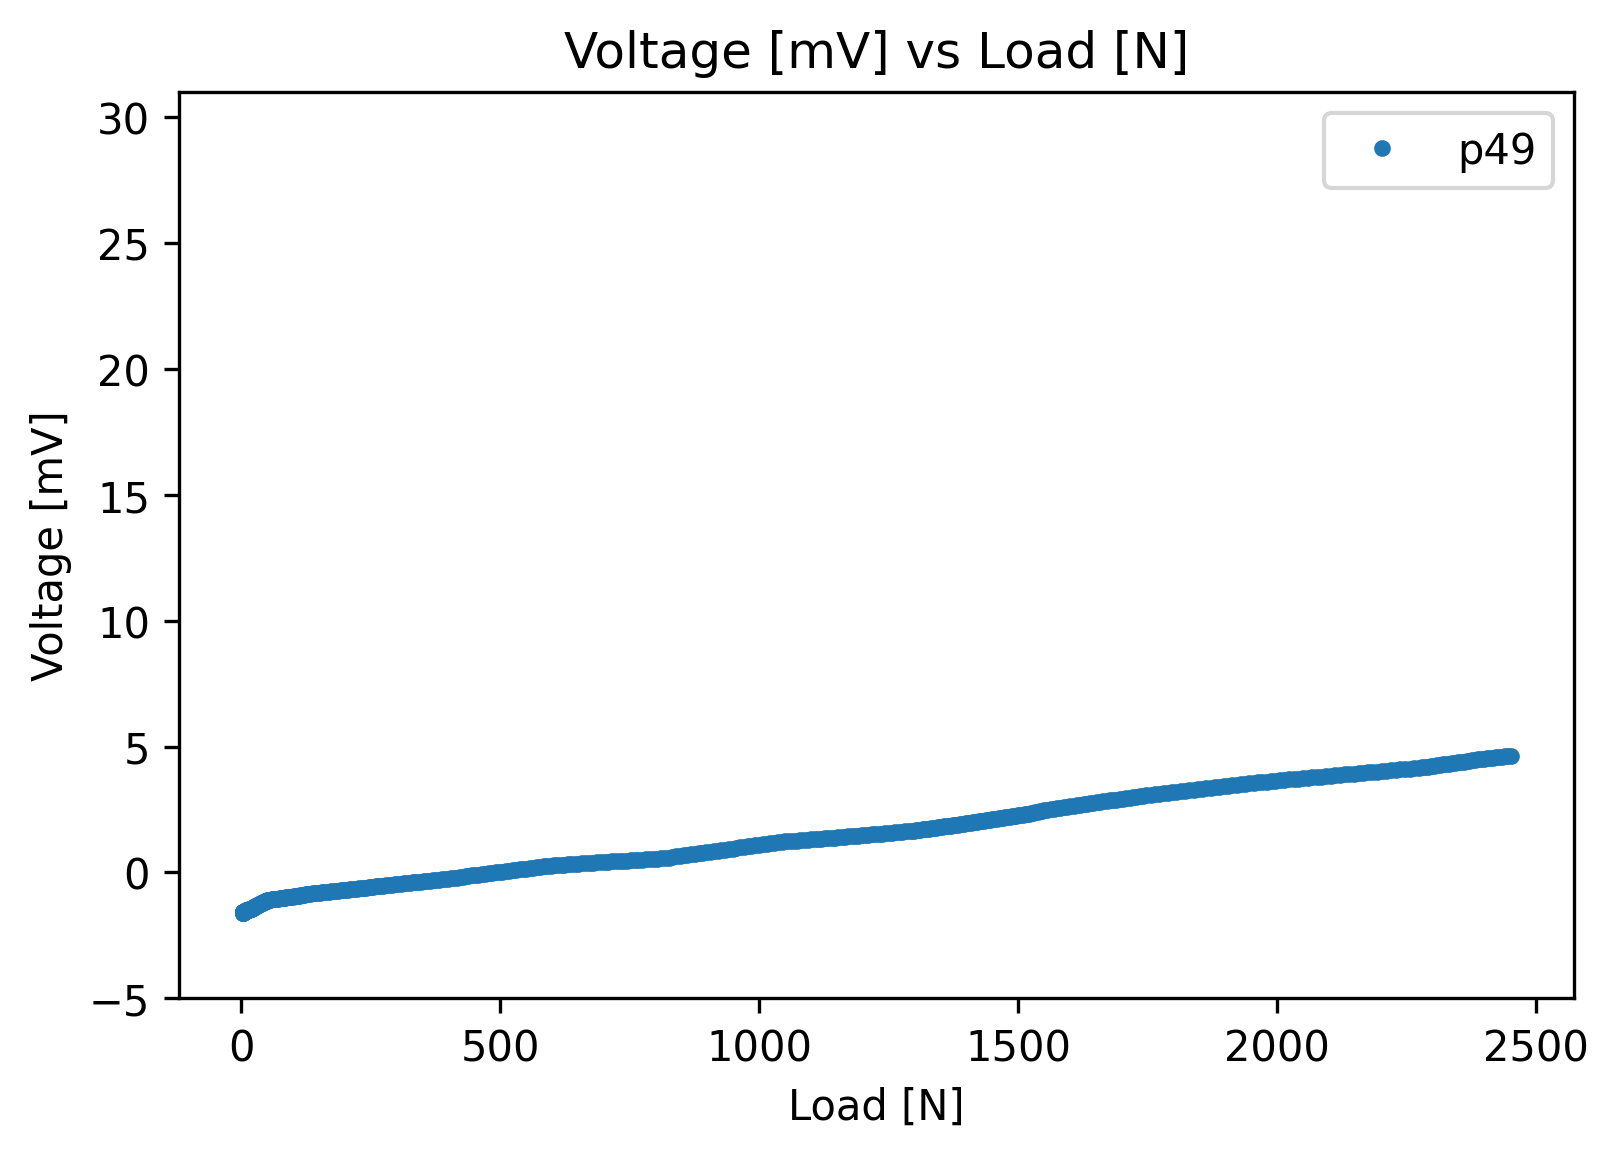

In [94]:
'''
Existen xx opciones (0 - XX) para seleccionar el tipo de gráfico a presentar, 
dado un conjunto de muestras 'pxx'
option = 0 --- fuerza vs tiempo
option = 1 --- deformación unitaria vs tiempo
option = 2 --- fuerza vs deformación unitaria
option = 3 --- voltaje vs tiempo
option = 4 --- corriente vs tiempo
option = 5 --- corriente vs voltaje
option = 6 --- voltaje vs deformación unitaria
option = 7 --- voltaje vs fuerza
option = 8 --- corriente vs deformación unitaria
option = 9 --- resistencia vs deformacion unitaria
option = 10 --- resistencia vs fuerza
option = 11 --- potencia vs tiempo
option = 12 --- resistencia vs tiempo
option = 13 --- Delta de resistencia / R vs deformacion unitaria
option = 14 --- Delta de resistencia / R vs tiempo
option = 15 --- voltaje / distancia entre electrodos vs fuerza / área sección transversal
option = 16 --- deformación unitaria normalizada vs tiempo
option = 17 --- corriente normalizada vs tiempo
'''
idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[0,19], n=500)
data = dic_data_by_sample

#xylabel = plot_electromechanical(data, idata, option=7, marker='--', etiqueta='', dpi=100)
xylabel = plot_electromechanical(data, idata, option=7, marker='.', etiqueta='', dpi=300)

ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

save_VL = 'outputs/fig_GO/'
voltage_load = open(save_VL+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+
                    xylabel[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x)):
   voltage_load.write('%0.3f %0.3f\n' %(x[s], y[s]))
voltage_load.close()

## 2.1. Cálculo de factor piezoeléctrico $d_{33}$

In [ ]:
# calculo d33 a partir de medidas de capacitana (CV) y pendientes opción 7
# muestra: p39 p40 p41 ...
# indice:   0   1    2 ...

d = np.array([3680697.987536103, 4199307.964511792, 3457372.3030530754,
              2796189.454996852, 3870193.1752305217, 2983896.788102214,
              1596359.9563162734, 1048117.9160407293, 2336511.230140543,
              1631255.1094868754, 2449825.521396303, 3106032.526835843])
c = np.array([237.732, 290.109, 395.780, 339.791, 290.291, 330.374, 454.048, 
              414.039, 504.566, 380.482, 450.645, 277.588])*1e-6

muestras = ['p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47',
            'p48', 'p49', 'p50']

dic_c = {}
i = -1
for s in muestras:
  i += 1
  dic_c[s] = d[i] * c[i]

dic_c

{'p39': 875.0196939729328,
 'p40': 1218.2570342765514,
 'p41': 1368.358810102346,
 'p42': 950.1200111028354,
 'p43': 1123.4822470308434,
 'p44': 985.801917472481,
 'p45': 724.8240454454913,
 'p46': 433.96169383958744,
 'p47': 1178.924125347093,
 'p48': 620.6632065677853,
 'p49': 1104.0016220896368,
 'p50': 862.1973570593079}

## 2.2. piezovoltaje simualción vs data

En 1.1. debes seleccionar solo una muestra, para comparar con su respectiva simulación.

In [ ]:
fname = 'OCP_'+picked_samples[0]+'_sim.png'
get_path = 'data/20220406_e_Malaga/'
save_fpath = 'outputs/fig_GO/simulated/'

idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[1,160], n=500)
data = dic_data_by_sample

xylabel = plot_electromechanical(data, idata, option=3, marker='.', etiqueta='Experimental data', dpi=300)

ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

voltage_time = open(save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+
                    xylabel[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x)):
   voltage_time.write('%0.3f %0.3f\n' %(x[s], y[s]))
voltage_time.close()

OCP = np.loadtxt(get_path+'OCP_'+picked_samples[0]+'_sim.txt')
ts = OCP[:,0]
vs = OCP[:,1]
isim = OCP[:,2]

plt.plot(ts, vs*1000, '-k', label='Model')
plt.legend()
#plt.plot(ts, isim*3e6, '-k')

plt.savefig(save_fpath+fname, dpi=300)

## 2.3. Almacenamiento de figuras y rutas

In [ ]:
base_path = 'outputs/fig_GO/' # ruta base para guardar .png y .xls
dpi_save = 300 # resolución en pixel con que será guardada la figura.
df_dataA = pd.DataFrame([]) # DataFrame con resultados de los análisis de datos y gráficas.
df_fig_path = pd.DataFrame([]) # DataFrame con paths de las figuras separados por tipos de gráfica.

try: # se llaman archivos .xlsx con cálculos y paths de las figuras, si no existen sigue ejecutando el código.
  df_dataA = pd.read_excel(base_path+'dataA_GO.xlsx', sheet_name="analytics")
  df_fig_path = pd.read_excel(base_path+'fig_GO.xlsx', sheet_name="figs")
except:
  pass

tmi = []
tma = []
sample = ''
for ss3 in picked_samples: # nombre de muestra. 
  tmi = np.append(tmi, idata[ss3][0].min())
  tma = np.append(tma, idata[ss3][0].max())
  sample = ss3+'_'+sample

tmin = '%0.2f' % np.mean(tmi) # tiempo inicial.
tmax = '%0.2f' % np.mean(tma) # tiempo final.

#tmin = '%0.2f' % idata[ss3][0].min() # tiempo inicial.
#tmax = '%0.2f' % idata[ss3][0].max() # tiempo final.

  # metodología para nombrar figuras en base al nombre de la muestra, tipo de gráfico
  # y rango de tiempo representado.
xl = xylabel[0]
yl = xylabel[1]
fig_name = sample+yl.split()[0]+'_'+xl.split()[0]+'_'+tmin+'_to_'+tmax+'.png'

xylabel[2].savefig(base_path+fig_name, dpi=dpi_save) # guardando figura.

column = yl+' vs '+xl # columna donde se etiquetará el titulo de la figura.

  # pregunta si el encabezado de la columna se encuentra en el DataFrame cargado.
k = df_fig_path.columns == column
if k.sum() == 1:  
  ds = df_fig_path[column] # convierte columna en DataSeries
  idx = ds.last_valid_index() # último indice con celda escrita en el DataSeries
  if df_fig_path.at[idx, column] != base_path+fig_name: # Evita repetir path
    df_fig_path.at[idx+1, column] = base_path+fig_name # escribiendo el path de la figura.
else:
  df_fig_path.at[0, column] = base_path+fig_name # escribiendo el path de la figura.

# Se crean archivos .xlsx con cálculos y paths de las figuras.
df_dataA.to_excel(base_path+'dataA_GO.xlsx', sheet_name='analytics', index=False)
df_fig_path.to_excel(base_path+'fig_GO.xlsx', sheet_name='figs', index=False)

In [ ]:
df_fig_path

,Deformación [mm] vs Tiempo [s],Fuerza [kN] vs Deformación [mm],Voltaje [mV] vs Tiempo [s],Corriente [$\mu$A] vs Tiempo [s],Corriente [$\mu$A] vs Deformación [mm],Voltaje [mV] vs Deformación unitaria [$\mu \epsilon$],Resistencia [k$\Omega$] vs Deformación unitaria [$\mu \epsilon$],Voltage [mV] vs Time [s],Voltage [mV] vs Load [kN],Voltage [mV] vs Load [N]
0,outputs/fig_GO/p40_p39_Deformación_Tiempo_2.36...,outputs/fig_GO/p40_p39_Fuerza_Deformación_2.36...,outputs/fig_GO/p40_p39_Voltaje_Tiempo_2.36_to_...,outputs/fig_GO/p40_p39_Corriente_Tiempo_2.36_t...,outputs/fig_GO/p41_p40_p39_Corriente_Deformaci...,outputs/fig_GO/p40_Voltaje_Deformación_2.16_to...,outputs/fig_GO/p40_Resistencia_Deformación_2.1...,outputs/fig_GO/p44_p43_p42_p41_p40_p39_Voltage...,outputs/fig_GO/p39_Voltage_Load_2.56_to_16.00.png,outputs/fig_GO/p44_p41_p40_Voltage_Load_2.22_t...
1,NaN,NaN,outputs/fig_GO/p42_p41_Voltaje_Tiempo_2.26_to_...,outputs/fig_GO/p42_p41_Corriente_Tiempo_2.26_t...,NaN,NaN,NaN,NaN,outputs/fig_GO/p44_p43_p42_p41_p40_p39_Voltage...,outputs/fig_GO/p49_p48_p45_Voltage_Load_2.62_t...
2,NaN,NaN,outputs/fig_GO/p44_p43_Voltaje_Tiempo_2.36_to_...,outputs/fig_GO/p44_p43_Corriente_Tiempo_2.36_t...,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,outputs/fig_GO/p44_p43_p42_p41_Voltaje_Tiempo_...,outputs/fig_GO/p44_p43_p42_p41_Corriente_Tiemp...,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,outputs/fig_GO/p50_p49_p48_p47_Voltaje_Tiempo_...,outputs/fig_GO/p50_p49_p48_p47_Corriente_Tiemp...,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,outputs/fig_GO/p41_p40_p39_Voltaje_Tiempo_2.29...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.0. Analisis voltamperogramas

En 1.1. se debe seleccionar solo una muestra, entre p39, p40 y p41

In [ ]:
# Recorrer sobre las muestras
# En cada muestra recorrer sobre las medidas de interes para crear un nuevo data frame

dic_info_by_sample = {}
dic_info_by_sample = dic_info_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  s_sample = data['specimen'] == ss1
  sx = data[s_sample]
  s_measure = (sx['measure'] == 'CV')
  sx[s_measure] # DataFrame with electric-mechanic measurements by sample "pxx"
  dic_info_by_sample[ss1] = sx[s_measure] # DataFrames e-m by pxx into dictionary 

dic_info_by_sample

In [ ]:
# Diccionario con los datos eléctricos de los voltamperogramas de cada muestra pxx a diferentes fuerzas

dic_data_by_load = {}

for ss1 in picked_samples:
  for ss2 in dic_info_by_sample[ss1].path.values:
    sl1 = ss2.split("kg") # separa path en una lista donde el elemento 5 es la carga en kg
    sl2 = list(sl1[0].split("_"))
    e_data = np.loadtxt('data/'+ss2) # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
    #print(ss2)
    e_t = e_data[:,0]*1e-3 #columna 1 tiempo en [s]
    v = e_data[:,1]*1e3 #columna 2 voltaje en [mV]
    i = e_data[:,2]*1e6 #columna 3 corriente en [uA]
    
    dic_data_by_load[ss1+'_'+sl2[4]] = np.array([e_t, v, i])

#dic_data_by_load

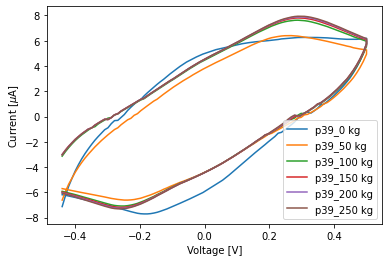

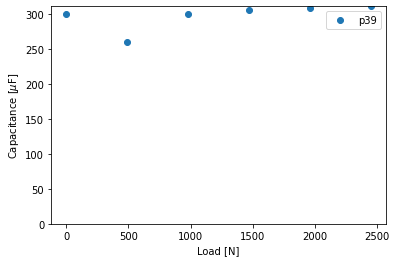

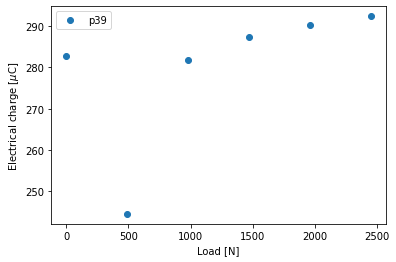

In [ ]:
dpi = 300
plt.figure(1)
fname_cv = 'CV_'+picked_samples[0]+'.png'
fname_c = 'C_'+picked_samples[0]+'.png'
fname_q = 'Q_'+picked_samples[0]+'.png'
save_fpath = 'outputs/fig_GO/voltammetry/'

data_C = open(save_fpath+'cap_'+picked_samples[0]+'.txt', mode='w+')
data_q = open(save_fpath+'charge_'+picked_samples[0]+'.txt', mode='w+')

dic_cap = {}
dic_q = {}
xc = []
yc = []
xq = []
yq = []

for ss2 in dic_data_by_load.keys():
  # medidas eléctricas
  e_t = dic_data_by_load[ss2][0] # índice "0": tiempo en [s]
  v = dic_data_by_load[ss2][1]/1e3 # índice "1": voltaje en [V]
  i = dic_data_by_load[ss2][2] # índice "2": corriente en [uA]

  sj = int(len(v)/2)  
  i1 = i[0:sj]
  v1 = v[0:sj]
  i2 = i[sj:len(v)]
  v2 = v[sj:len(v)]
  
  vmin = -0.44
  vmax = v.max()

  ss = (v >= vmin) & (v <= vmax)
  ss0 = (v1 >= vmin) & (v1 <= vmax)
  ss1 = (v2 >= vmin) & (v2 <= vmax)

  iaux1 = i1[ss0] - i2.min()
  vaux1 = v1[ss0]
  iaux2 = i2[ss1] - i2.min()
  vaux2 = v2[ss1]
  
  a1 = integral.simps(iaux1, vaux1)
  a2 = integral.simps(iaux2, vaux2)
  a = a1 - a2 # integral de la corriente en función del voltaje en la ventana de portencial
  dic_cap[ss2] = 0.5 * a / 25e-3 / (vmax - vmin) # capacitancia para cada carga mecánica [uF]
  dic_q[ss2] = 0.5 * a / 25e-3 # carga eléctrica para cada carga mecánica [uC]

  #-----------------------------------------------------------------------------
  # salvar datos de capacitancia y carga eléctrica en .txt y en listas xc y yc
  xc_s = float(ss2.split('_')[1])*9.8067 # N
  yc_s = dic_cap[ss2]
  xc = np.append(xc, xc_s)
  yc = np.append(yc, yc_s)
  data_C.write('%0.3f %0.3f\n' %(xc_s, yc_s))

  xq_s = float(ss2.split('_')[1])*9.8067 # N
  yq_s = dic_q[ss2]
  xq = np.append(xq, xq_s)
  yq = np.append(yq, yq_s)
  data_q.write('%0.3f %0.3f\n' %(xq_s, yq_s))
  #-----------------------------------------------------------------------------

  plt.plot(v[ss], i[ss], '-', label=ss2+' kg')


data_C.close()
data_q.close()

plt.xlabel(r'Voltage [V]')
plt.ylabel(r'Current [$\mu$A]')
plt.legend()
plt.savefig(save_fpath+fname_cv, dpi=dpi)
plt.show()

plt.figure(2)
plt.plot(xc, yc, 'o', label=picked_samples[0])
plt.xlabel(r'Load [N]')
plt.ylabel(r'Capacitance [$\mu$F]')
plt.ylim(0, yc.max())
plt.legend()
plt.savefig(save_fpath+fname_c, dpi=dpi)
plt.show()

plt.figure(3)
plt.plot(xq, yq, 'o', label=picked_samples[0])
plt.xlabel(r'Load [N]')
plt.ylabel(r'Electrical charge [$\mu$C]')
plt.legend()
plt.savefig(save_fpath+fname_q, dpi=dpi)
plt.show()

In [ ]:
yc.std()

17.274865380098685

# 4.0. Análisis particle size distribution

In [20]:
fig_save_path = 'outputs/fig_GO'
dpi = 300
measurement = 'Measurement 1', 'Measurement 2', 'Measurement 3'
#measu_type = 'AuNPs', 'GONPs', 'GraphiteNPs'
file_name = 'Daniel Triana_GONPs_Branson_90_20200306', 'Daniel Triana_GONPs_punta_90_20200306'
par_dia = 'Unnamed: 5' #Particle diameter [nm]
rel_int = 'Unnamed: 6' #Relative frequency Intensity weighted [%]
start_data = 7
end_data = 148
ps_fig_df = pd.DataFrame([])
time_line_df = pd.DataFrame([])

if not os.path.exists(fig_save_path):
  os.mkdir(fig_save_path)

index = -1
label = 'Method 1', 'Method 2'
mar = 's-', 'v-'
plt.figure()

for fn in file_name:
  index += 1
  data = pd.read_excel('data/20200306_DLS/'+fn+'.xlsx', sheet_name=measurement[0])
  ps = data.loc[start_data:end_data, par_dia]
  ri = data.loc[start_data:end_data, rel_int]
  peak = max(ri)
  s = ri == peak
  ps_max = ps[s]
  #time_line_df.at[index, 'time [days]'] = day
  #time_line_df.at[index, 'surfactant'] = dis
  #time_line_df.at[index, 'energy [kJ]'] = e
  #time_line_df.at[index, 'Intensity [%]'] = peak.values[0]
  #time_line_df.at[index, 'particle size [nm]'] = ps_max.values[0]
  plt.plot(ps, ri, mar[index], label=label[index])
  plt.plot(ps_max, peak, 'or')
  print(ps_max, peak)

plt.xlim(1e2, ps.max())
plt.xscale('log')
plt.xlabel('Particle size [nm]')
plt.ylabel('Intensity [%]')
fig_path = os.path.join(fig_save_path, u'ps_GO.png')
plt.legend()
#plt.title('DLS_day_'+day)
plt.savefig(fig_path, dpi=dpi)
plt.close()
#ps_fig_df.at[index_f, 'energy'] = e
#ps_fig_df.at[index_f, 'ps_day_'+day] = fig_path  
    
#time_line_df.to_excel('outputs/time_line_ps.xlsx', sheet_name='data', index=False)
#print(time_line_df)
#ps_fig_df.to_excel('outputs/ps_fig.xlsx', sheet_name='plots', index=False)
#ps_fig_df

100    391.279669
Name: Unnamed: 5, dtype: object 14.6776997906788
112    1034.184049
Name: Unnamed: 5, dtype: object 6.14359290474918


### Estadística de pendientes.

In [ ]:
# v vs t
slopes_p40 = np.array([0.84996, 0.652643, 0.5944, 0.5876, 0.5164, 0.5229])
np.mean(slopes_p40)

# v vs pos
slopes_p40 = np.array([51.86, 39.86, 35.98, 35.22, 31.31, 31.72])
np.mean(slopes_p40)

# v vs f
slopes_p40 = np.array([4.1823, 3.2697, 2.8906, 2.8445, 2.5050, 2.5334])
np.mean(slopes_p40)

3.0375833333333335

In [ ]:
fig_base_path = 'outputs/GO_Malaga'
dpi = 300
file_name = 'UV_day_1', 'UV_day_15', 'UV_day_30', 'UV_day_45', 'UV_day_90'
time = np.array([1, 15, 30, 45, 90])
energy = '190', '390', '590'
surfactant = 'Sika ', 'Eucon ', 'Tx '

UV_fig_df = pd.DataFrame([])
time_line_df = pd.DataFrame([])

if not os.path.exists(fig_base_path):
  os.mkdir(fig_base_path)

index = -1
plt.figure(1)

for day in file_name:
  index_e = -1
  for e in energy:
    index_e += 1
    for dis in surfactant:
      data = pd.read_excel('data/20220406_e_Malaga/'+day+'.xlsx', sheet_name="Hoja1")
      wave = data['Wavelength (nm)1']
      absorbance = data['Absorbance (AU)1']
      s = np.int16(np.linspace(0, wave.size-1, 70))
      wave_resize = wave[s]
      absorbance_resize = absorbance[s]
      a = 200
      b = 400
      ran = (wave_resize <= b) & (wave_resize >= a)
      if dis == 'Sika ':
        a_si = 220
        b_si = b
        ran_si = (wave <= b_si) & (wave >= a_si)
        wave_si = wave[ran_si]
        absorbance_si = absorbance[ran_si]
        ss = absorbance_si == max(absorbance_si)
        pi_plasmon = wave_si[ss]
        peak = absorbance_si[ss]
      if dis == 'Eucon ':
        a_eu = 275
        b_eu = b
        ran_eu = (wave <= b_eu) & (wave >= a_eu)
        wave_eu = wave[ran_eu]
        absorbance_eu = absorbance[ran_eu]
        ss = absorbance_eu == max(absorbance_eu)
        pi_plasmon = wave_eu[ss]
        peak = absorbance_eu[ss]
      if dis == 'Tx ':
        a_tx = 250
        b_tx = b
        ran_tx = (wave <= b_tx) & (wave >= a_tx)
        wave_tx = wave[ran_tx]
        absorbance_tx = absorbance[ran_tx]
        ss = absorbance_tx == max(absorbance_tx)
        pi_plasmon = wave_tx[ss]
        peak = absorbance_tx[ss]

      index += 1
      t = [int(sss) for sss in day.split('_') if sss.isdigit()]
      time_line_df.at[index, 'time [days]'] = t[0]
      time_line_df.at[index, 'surfactant'] = dis
      time_line_df.at[index, 'energy [kJ]'] = e
      time_line_df.at[index, 'plasmon_abs [AU]'] = peak.values[0]
      time_line_df.at[index, 'plasmon_wave [nm]'] = pi_plasmon.values[0]

      label = dis+e+u', $\pi-plasmon$ = '+str(pi_plasmon.values[0])+' nm, Ab_peak = '+str(peak.values[0])+' AU'
      plt.plot(pi_plasmon, peak, 'or')
      plt.plot(wave_resize[ran], absorbance_resize[ran], '--', label=label)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorbance [AU]')
    fig_path = os.path.join(fig_base_path, u'%s_%s.png' % (day, e))
    plt.legend()
    plt.title(day)
    plt.savefig(fig_path, dpi=dpi)
    plt.close()
    UV_fig_df.at[index_e, 'energy'] = e
    UV_fig_df.at[index_e, day] = fig_path  
    
time_line_df.to_excel('outputs/time_line_plasmon.xlsx', sheet_name='data', index=False)
print(time_line_df)
UV_fig_df.to_excel('outputs/UV_fig.xlsx', sheet_name='plots', index=False)
UV_fig_df